# Imports

In [114]:
from numpy.random import seed
seed(10)
import tensorflow 
tensorflow.random.set_seed(404)


import os
from time import strftime
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import cifar10

import itertools

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [102]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
LOG_DIR = 'tensorboard_cifar_logs/'
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS

VALIDATION_DATASET_SIZE = 10000

SMALL_TRAIN_SIZE = 1000

NUM_OF_CLASSES = 10

# Get the dataset

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# Exploring the Dataset

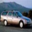

In [4]:
pic = array_to_img(x_train_all[4])
display(pic)


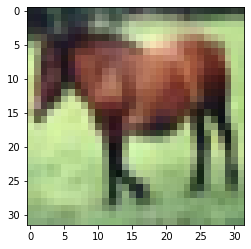

In [5]:
plt.imshow(x_train_all[7])

In [6]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

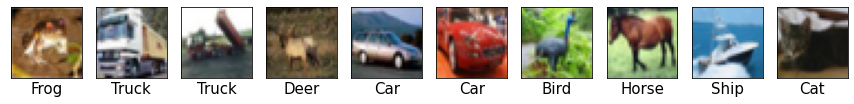

In [7]:
# displaying the first ten images from the dataset
plt.figure(figsize=(15, 6))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=15)
  plt.imshow(x_train_all[i])

In [8]:
# displaying the structure of the datasets

nr_images, w, h, c = x_train_all.shape

print(f'Images = {nr_images} \t|  width = {w} \t|  height = {h} \t|  channels = {c}')

Images = 50000 	|  width = 32 	|  height = 32 	|  channels = 3


In [9]:
x_test.shape

(10000, 32, 32, 3)

# Preprocessing

In [10]:
# scaling the dataset to the range [0, 1]
x_train_all, x_test = x_train_all/255.0, x_test/255.0   # dividing by 255 becuase the maximum value of a RGB component is 255.

In [11]:
# flattering the dataset from 4D to 1D
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

x_train_all.shape

(50000, 3072)

In [12]:
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)

print(f'Shape of x_test is: {x_test.shape}')

Shape of x_test is: (10000, 3072)


# Creating Validation Dataset

In [13]:
x_val = x_train_all[:VALIDATION_DATASET_SIZE]
y_val = y_train_all[:VALIDATION_DATASET_SIZE]

In [14]:
# exlude the validation dataset from the training dataset

x_train = x_train_all[VALIDATION_DATASET_SIZE:]
y_train = y_train_all[VALIDATION_DATASET_SIZE:]

In [15]:
print(f'The size of X_train is: {x_train.shape}')
print(f'The size of y_train is: {y_train.shape}')

The size of X_train is: (40000, 3072)
The size of y_train is: (40000, 1)


# Creating a small size (subset) of the training data for illustration. (I don't wanna screw my laptop up! LOL)

In [16]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Building a Keras Neural Network Model

In [44]:

model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(16, activation='relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [23]:
# Let's run the summary method on the model 

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [45]:
# model2

model_2 = Sequential()

model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name="hidden_L1"))
model_2.add(Dense(64, activation='relu', name="hidden_L2"))
model_2.add(Dense(16, activation='relu', name="hidden_L3"))
model_2.add(Dense(10, activation='softmax', name="output_L"))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])


In [46]:
# model3

model_3 = Sequential()

model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name="hidden_L1"))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name="hidden_L2"))
model_3.add(Dense(16, activation='relu', name="hidden_L3"))
model_3.add(Dense(10, activation='softmax', name="output_L"))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])


# Tensorboard - Visualizing the learning process

In [24]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    return TensorBoard(dir_paths)

# Fitting the model

In [47]:
samples_per_batch = 1000
num_of_epochs = 100

In [43]:
# %%time

# model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch,
#             epochs=num_of_epochs, callbacks=[get_tensorboard('Model 1')], 
#             verbose=0, validation_data=(x_val, y_val))

In [48]:
%%time

model_1.fit(x_train, y_train, batch_size=samples_per_batch,
            epochs=num_of_epochs, callbacks=[get_tensorboard('Model 1 FD')], 
            verbose=0, validation_data=(x_val, y_val))

CPU times: total: 7min 3s
Wall time: 1min 40s


In [49]:
%%time

model_2.fit(x_train, y_train, batch_size=samples_per_batch,
            epochs=num_of_epochs, callbacks=[get_tensorboard('Model 2 FD')], 
            verbose=0, validation_data=(x_val, y_val))

CPU times: total: 16min 21s
Wall time: 3min 1s


In [50]:
%%time

model_3.fit(x_train, y_train, batch_size=samples_per_batch,
            epochs=num_of_epochs, callbacks=[get_tensorboard('Model 3 FD')], 
            verbose=0, validation_data=(x_val, y_val))

CPU times: total: 19min 53s
Wall time: 3min 49s


# Making predictions on the individual images

In [53]:
np.set_printoptions(precision=3)

In [54]:
test = np.expand_dims(x_val[0], axis=0)

model_2.predict(test)

1/1 [==============================] - 0s 130ms/step


array([[0.036, 0.011, 0.117, 0.208, 0.085, 0.164, 0.316, 0.062, 0.001,
        0.001]], dtype=float32)

In [63]:
np.argmax(model_2.predict(test),axis=1)

1/1 [==============================] - 0s 27ms/step


array([6], dtype=int64)

In [60]:
# this confirms the model had the correct prediction.
y_val[0]

array([6], dtype=uint8)

In [70]:
for i in range(0, 10):
    test_img = np.expand_dims(x_val[i], axis=0)
    predicted = np.argmax(model_2.predict(test_img), axis=1)[0]
    print(f'Predicted: {LABEL_NAMES[predicted]} vs Actual: {LABEL_NAMES[y_val[i][0]]}')
   

1/1 [==============================] - 0s 25ms/step
Predicted: Frog vs Actual: Frog
1/1 [==============================] - 0s 17ms/step
Predicted: Car vs Actual: Truck
1/1 [==============================] - 0s 20ms/step
Predicted: Truck vs Actual: Truck
1/1 [==============================] - 0s 26ms/step
Predicted: Frog vs Actual: Deer
1/1 [==============================] - 0s 38ms/step
Predicted: Car vs Actual: Car
1/1 [==============================] - 0s 22ms/step
Predicted: Truck vs Actual: Car
1/1 [==============================] - 0s 22ms/step
Predicted: Frog vs Actual: Bird
1/1 [==============================] - 0s 20ms/step
Predicted: Horse vs Actual: Horse
1/1 [==============================] - 0s 17ms/step
Predicted: Plane vs Actual: Ship
1/1 [==============================] - 0s 19ms/step
Predicted: Bird vs Actual: Cat


# Evaluation

In [76]:
test_loss, test_acc = model_2.evaluate(x_test, y_test)
print(f'The test loss is {test_loss:0.3} and the test accuracy is {test_acc:0.2%}')

313/313 [==============================] - 1s 2ms/step - loss: 1.4409 - accuracy: 0.4858
The test loss is 1.44 and the test accuracy is 48.58%


## Confusion matrix

In [94]:
predictions = np.argmax(model_2.predict(x_test), axis=1)
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)

313/313 [==============================] - 1s 2ms/step


In [95]:
conf_mat

array([[575,  34,  52,  22,  31,  15,  24,  23, 194,  30],
       [ 56, 597,  10,  36,  14,  16,  17,  17, 127, 110],
       [103,  23, 281, 102, 193,  81, 123,  45,  36,  13],
       [ 41,  26,  83, 323,  62, 197, 141,  48,  45,  34],
       [ 65,  12, 108,  55, 491,  51, 118,  57,  36,   7],
       [ 33,  13,  84, 229,  72, 363,  89,  61,  41,  15],
       [ 14,  15,  56, 101, 134,  51, 582,  14,  20,  13],
       [ 69,  20,  46,  68, 126,  70,  43, 498,  25,  35],
       [ 96,  60,   8,  28,  16,  26,  13,   8, 709,  36],
       [ 60, 199,   9,  39,  13,  21,  36,  46, 138, 439]], dtype=int64)

In [96]:
conf_mat.max()

709

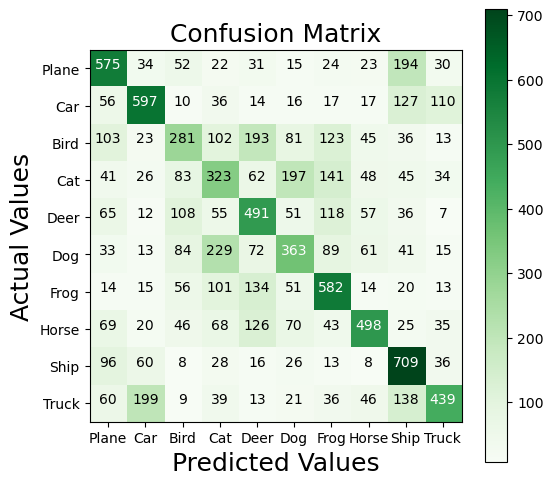

In [133]:
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(conf_mat, cmap=plt.cm.Greens)
plt.title("Confusion Matrix", fontsize=18)
plt.ylabel("Actual Values", fontsize=18)
plt.xlabel("Predicted Values", fontsize=18)

tick_marks = np.arange(NUM_OF_CLASSES)

plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

# printing the value of each box in the conf matrix

for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, conf_mat[i, j], horizontalalignment='center',
            color='white' if conf_mat[i, j] > conf_mat.max()/2 else 'black')

plt.colorbar()
plt.show()

In [134]:
recall = np.diag(conf_mat)/ np.sum(conf_mat, axis=1)
recall

array([0.575, 0.597, 0.281, 0.323, 0.491, 0.363, 0.582, 0.498, 0.709,
       0.439])

In [135]:
precision = np.diag(conf_mat)/np.sum(conf_mat, axis=0)
precision

array([0.517, 0.598, 0.381, 0.322, 0.426, 0.407, 0.491, 0.61 , 0.517,
       0.6  ])

In [143]:
avg_recall = np.mean(recall)

print(f'The average recall score of model 2 is: {avg_recall}')

The average recall score of model 2 is: 0.48579999999999995


In [144]:
avg_precision = np.mean(precision)

print(f'The average precision score of model 2 is: {avg_precision}')

The average precision score of model 2 is: 0.4868755752213175


In [147]:
f_sc = 2*(avg_recall*avg_precision)/(avg_recall + avg_precision)

print(f'The average f_score of the model is: {f_sc:0.3}')

The average f_score of the model is: 0.486
